# Setup

In [158]:
# imports
import pandas as pd
import seaborn as sns
from scipy import stats

In [2]:
# constants
RELEASED_VERSIONS = ["2.0.0", "2.0.1",
                     "2.1.0", "2.1.1", "2.2.0",
                     "2.3.0", "2.3.1", "2.3.2", "2.3.3", "2.3.4", "2.3.5", "2.3.6", "2.3.7", "2.3.8", "2.3.9",
                     "3.0.0", "3.1.0", "3.1.1", "3.1.2", "3.1.3"]

INPUT_DIR = "../../data/input/"
OUTPUT_DIR = "../../data/output/"

# Load data

We take a look at the raw metrics data to know how to process it 

In [3]:
df = pd.read_csv(INPUT_DIR + "hive-metrics-v2/2.0.0.csv")
df.head()

,Kind,Name,File,AltAvgLineBlank,AltAvgLineCode,AltAvgLineComment,AltCountLineBlank,AltCountLineCode,AltCountLineComment,AvgCyclomatic,...,MaxInheritanceTree,MaxNesting,MinEssentialKnots,PercentLackOfCohesion,PercentLackOfCohesionModified,RatioCommentToCode,SumCyclomatic,SumCyclomaticModified,SumCyclomaticStrict,SumEssential
0,Class,Apache::Hadoop::Hive::AbortTxnRequest,metastore\src\gen\thrift\gen-cpp\hive_metastor...,0.0,7.0,0.0,16.0,88.0,0.0,1.0,...,0.0,3.0,NaN,27.0,NaN,0.0,16.0,16.0,16.0,12.0
1,Public Function,Apache::Hadoop::Hive::AbortTxnRequest::AbortTx...,metastore\src\gen\thrift\gen-cpp\hive_metastor...,NaN,NaN,NaN,0.0,3.0,0.0,NaN,...,NaN,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN
2,Public Function,Apache::Hadoop::Hive::AbortTxnRequest::AbortTx...,metastore\src\gen\thrift\gen-cpp\hive_metastor...,NaN,NaN,NaN,0.0,2.0,0.0,NaN,...,NaN,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN
3,Public Function,Apache::Hadoop::Hive::AbortTxnRequest::__set_t...,metastore\src\gen\thrift\gen-cpp\hive_metastor...,NaN,NaN,NaN,0.0,3.0,0.0,NaN,...,NaN,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN
4,Public Const Function,Apache::Hadoop::Hive::AbortTxnRequest::operator!=,metastore\src\gen\thrift\gen-cpp\hive_metastor...,NaN,NaN,NaN,0.0,3.0,0.0,NaN,...,NaN,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN


In [10]:
df["Kind"].value_counts()

Public Method                         56475
Public Static Method                   6536
Private Method                         6531
Public Constructor                     6357
File                                   4992
                                      ...  
Protected Interface                       1
Private Static Final Generic Class        1
Public Static Final Generic Class         1
Static Final Method                       1
Private Generic Class                     1
Name: Kind, Length: 97, dtype: int64

We can see that we have metrics for not only files but also for packages, classes, and functions. Also, there are a lot more metrics than we want.
Therefore, we need to select precisely what we want from the dataset.

Below we can observe that classes' metrics don't have any value for files Kind.

In [16]:
classes_metrics_cols = ["CountClassBase", "CountClassCoupled", "CountClassDerived", "MaxInheritanceTree", "PercentLackOfCohesion"]
df.loc[df["Kind"] == "File"][classes_metrics_cols].describe().loc["count"]

CountClassBase           0.0
CountClassCoupled        0.0
CountClassDerived        0.0
MaxInheritanceTree       0.0
PercentLackOfCohesion    0.0
Name: count, dtype: float64

Same for methods' metrics

In [45]:
methods_metrics_cols = ["CountInput", "CountOutput", "CountPath", "MaxNesting"]
df.loc[df["Kind"] == "File"][methods_metrics_cols].describe().loc["count"]

CountInput        0.0
CountOutput       0.0
CountPath         0.0
MaxNesting     4992.0
Name: count, dtype: float64

### Data aggreation

We choose to aggregate those metrics with respect to the file they belong to.

#### Classes metrics

In [41]:
classes_data = df.loc[~(df["Kind"] == "File")][classes_metrics_cols + ["Name", "File"]].copy(deep=True)
classes_data

,CountClassBase,CountClassCoupled,CountClassDerived,MaxInheritanceTree,PercentLackOfCohesion,Name,File
0,0.0,1.0,0.0,0.0,27.0,Apache::Hadoop::Hive::AbortTxnRequest,metastore\src\gen\thrift\gen-cpp\hive_metastor...
1,NaN,NaN,NaN,NaN,NaN,Apache::Hadoop::Hive::AbortTxnRequest::AbortTx...,metastore\src\gen\thrift\gen-cpp\hive_metastor...
2,NaN,NaN,NaN,NaN,NaN,Apache::Hadoop::Hive::AbortTxnRequest::AbortTx...,metastore\src\gen\thrift\gen-cpp\hive_metastor...
3,NaN,NaN,NaN,NaN,NaN,Apache::Hadoop::Hive::AbortTxnRequest::__set_t...,metastore\src\gen\thrift\gen-cpp\hive_metastor...
4,NaN,NaN,NaN,NaN,NaN,Apache::Hadoop::Hive::AbortTxnRequest::operator!=,metastore\src\gen\thrift\gen-cpp\hive_metastor...
...,...,...,...,...,...,...,...
119314,NaN,NaN,NaN,NaN,NaN,writeByte,service\lib\py\thrift\protocol\fastbinary.c
119315,NaN,NaN,NaN,NaN,NaN,writeDouble,service\lib\py\thrift\protocol\fastbinary.c
119316,NaN,NaN,NaN,NaN,NaN,writeI16,service\lib\py\thrift\protocol\fastbinary.c
119317,NaN,NaN,NaN,NaN,NaN,writeI32,service\lib\py\thrift\protocol\fastbinary.c


In [42]:
classes_data.dropna(axis=0, subset=classes_metrics_cols, how='any', inplace=True)
classes_data

,CountClassBase,CountClassCoupled,CountClassDerived,MaxInheritanceTree,PercentLackOfCohesion,Name,File
0,0.0,1.0,0.0,0.0,27.0,Apache::Hadoop::Hive::AbortTxnRequest,metastore\src\gen\thrift\gen-cpp\hive_metastor...
11,0.0,3.0,0.0,0.0,36.0,Apache::Hadoop::Hive::AbortTxnsRequest,metastore\src\gen\thrift\gen-cpp\hive_metastor...
22,0.0,5.0,0.0,0.0,47.0,Apache::Hadoop::Hive::AddDynamicPartitions,metastore\src\gen\thrift\gen-cpp\hive_metastor...
37,0.0,3.0,0.0,0.0,36.0,Apache::Hadoop::Hive::AddForeignKeyRequest,metastore\src\gen\thrift\gen-cpp\hive_metastor...
48,0.0,4.0,0.0,0.0,47.0,Apache::Hadoop::Hive::AddPartitionsRequest,metastore\src\gen\thrift\gen-cpp\hive_metastor...
...,...,...,...,...,...,...,...
119269,1.0,9.0,0.0,2.0,0.0,org.apache.hive.testutils.junit.runners.Concur...,testutils\src\java\org\apache\hive\testutils\j...
119271,2.0,8.0,0.0,1.0,0.0,org.apache.hive.testutils.junit.runners.Concur...,testutils\src\java\org\apache\hive\testutils\j...
119274,2.0,8.0,0.0,1.0,58.0,org.apache.hive.testutils.junit.runners.model....,testutils\src\java\org\apache\hive\testutils\j...
119284,1.0,14.0,0.0,1.0,0.0,org.apache.tez.dag.api.TaskSpecBuilder,ql\src\java\org\apache\tez\dag\api\TaskSpecBui...


In [43]:
grouped_classes_data = classes_data.groupby(by="File").agg({
    "CountClassBase": "mean",
    "CountClassCoupled": "mean",
    "CountClassDerived": "mean",
    "MaxInheritanceTree": "max",
    "PercentLackOfCohesion": "mean",
})

grouped_classes_data.columns = ["AvgCountClassBase", "AvgCountClassCoupled", "AvgCountClassDerived", "MaxInheritanceTree", "AvgPercentLackOfCohesion"]
grouped_classes_data

,AvgCountClassBase,AvgCountClassCoupled,AvgCountClassDerived,MaxInheritanceTree,AvgPercentLackOfCohesion
File,,,,,
accumulo-handler\src\java\org\apache\hadoop\hive\accumulo\AccumuloConnectionParameters.java,1.0,18.0,1.0,1.0,70.0
accumulo-handler\src\java\org\apache\hadoop\hive\accumulo\AccumuloHiveConstants.java,1.0,3.0,0.0,1.0,0.0
accumulo-handler\src\java\org\apache\hadoop\hive\accumulo\AccumuloHiveRow.java,1.5,8.5,0.0,1.0,33.5
accumulo-handler\src\java\org\apache\hadoop\hive\accumulo\AccumuloStorageHandler.java,3.0,53.0,0.0,2.0,90.0
accumulo-handler\src\java\org\apache\hadoop\hive\accumulo\HiveAccumuloHelper.java,1.0,26.0,0.0,1.0,0.0
...,...,...,...,...,...
testutils\ptest2\src\test\java\org\apache\hive\ptest\execution\ssh\TestRSyncCommandExecutor.java,1.0,10.5,0.0,2.0,0.0
testutils\ptest2\src\test\java\org\apache\hive\ptest\execution\ssh\TestSSHCommandExecutor.java,1.0,10.0,0.0,2.0,0.0
testutils\src\java\org\apache\hive\testutils\jdbc\HiveBurnInClient.java,1.0,11.0,0.0,1.0,75.0


#### Methods metrics

In [46]:
methods_data = df.loc[~(df["Kind"] == "File")][methods_metrics_cols + ["Name", "File"]].copy(deep=True)
methods_data.dropna(axis=0, subset=methods_metrics_cols, how='any', inplace=True)
methods_data

,CountInput,CountOutput,CountPath,MaxNesting,Name,File
1,3.0,2.0,1.0,0.0,Apache::Hadoop::Hive::AbortTxnRequest::AbortTx...,metastore\src\gen\thrift\gen-cpp\hive_metastor...
2,0.0,2.0,1.0,0.0,Apache::Hadoop::Hive::AbortTxnRequest::AbortTx...,metastore\src\gen\thrift\gen-cpp\hive_metastor...
3,1.0,1.0,1.0,0.0,Apache::Hadoop::Hive::AbortTxnRequest::__set_t...,metastore\src\gen\thrift\gen-cpp\hive_metastor...
4,1.0,1.0,1.0,0.0,Apache::Hadoop::Hive::AbortTxnRequest::operator!=,metastore\src\gen\thrift\gen-cpp\hive_metastor...
5,2.0,2.0,1.0,0.0,Apache::Hadoop::Hive::AbortTxnRequest::operator=,metastore\src\gen\thrift\gen-cpp\hive_metastor...
...,...,...,...,...,...,...
119314,3.0,1.0,1.0,0.0,writeByte,service\lib\py\thrift\protocol\fastbinary.c
119315,4.0,2.0,1.0,0.0,writeDouble,service\lib\py\thrift\protocol\fastbinary.c
119316,3.0,2.0,1.0,0.0,writeI16,service\lib\py\thrift\protocol\fastbinary.c
119317,3.0,2.0,1.0,0.0,writeI32,service\lib\py\thrift\protocol\fastbinary.c


In [47]:
grouped_methods_data = methods_data.groupby(by="File").agg({
    "CountInput": "mean",
    "CountOutput": "mean",
    "CountPath": "mean",
    "MaxNesting": "max"
})

grouped_methods_data.columns = ["AvgCountInput", "AvgCountOutput", "AvgCountPath", "MaxNesting"]
grouped_methods_data

,AvgCountInput,AvgCountOutput,AvgCountPath,MaxNesting
File,,,,
accumulo-handler\src\java\org\apache\hadoop\hive\accumulo\AccumuloConnectionParameters.java,6.176471,3.941176,2.058824,2.0
accumulo-handler\src\java\org\apache\hadoop\hive\accumulo\AccumuloHiveRow.java,6.142857,3.142857,2.666667,3.0
accumulo-handler\src\java\org\apache\hadoop\hive\accumulo\AccumuloStorageHandler.java,4.476190,4.142857,5.571429,4.0
accumulo-handler\src\java\org\apache\hadoop\hive\accumulo\HiveAccumuloHelper.java,8.750000,5.750000,2.750000,2.0
accumulo-handler\src\java\org\apache\hadoop\hive\accumulo\LazyAccumuloMap.java,5.833333,8.500000,4.333333,2.0
...,...,...,...,...
testutils\ptest2\src\test\java\org\apache\hive\ptest\execution\ssh\TestRSyncCommandExecutor.java,2.500000,9.500000,1.500000,1.0
testutils\ptest2\src\test\java\org\apache\hive\ptest\execution\ssh\TestSSHCommandExecutor.java,2.000000,9.500000,1.500000,1.0
testutils\src\java\org\apache\hive\testutils\jdbc\HiveBurnInClient.java,4.000000,4.250000,2.500000,2.0


### Dataset creation

We therefore choose to only collect files' metrics as we are trying to predict bugs at files level.

In [55]:
metrics_cols = ["Name", "AvgCyclomatic", "AvgCyclomaticModified", "AvgCyclomaticStrict", "AvgEssential", "AvgLine", "AvgLineBlank", "AvgLineCode", 
    "AvgLineComment", "CountDeclClass", "CountDeclClassMethod", "CountDeclClassVariable", "CountDeclFunction", "CountDeclInstanceMethod",
    "CountDeclInstanceVariable", "CountDeclMethod", "CountDeclMethodDefault", "CountDeclMethodPrivate", "CountDeclMethodProtected",
    "CountDeclMethodPublic", "CountLine", "CountLineBlank", "CountLineCode", "CountLineCodeDecl", "CountLineCodeExe", "CountLineComment", 
    "CountSemicolon", "CountStmt", "CountStmtDecl", "CountStmtExe", "MaxCyclomatic", "MaxCyclomaticModified", "MaxCyclomaticStrict", 
    "RatioCommentToCode", "SumCyclomatic", "SumCyclomaticModified", "SumCyclomaticStrict", "SumEssential"]

data = df.loc[df["Kind"] == "File"][metrics_cols]
data.describe()

,AvgCyclomatic,AvgCyclomaticModified,AvgCyclomaticStrict,AvgEssential,AvgLine,AvgLineBlank,AvgLineCode,AvgLineComment,CountDeclClass,CountDeclClassMethod,...,CountStmtDecl,CountStmtExe,MaxCyclomatic,MaxCyclomaticModified,MaxCyclomaticStrict,RatioCommentToCode,SumCyclomatic,SumCyclomaticModified,SumCyclomaticStrict,SumEssential
count,4992.000000,4992.000000,4992.000000,4992.000000,4992.000000,4992.000000,4992.000000,4992.000000,4992.000000,4953.000000,...,4992.000000,4992.000000,4992.000000,4992.000000,4992.000000,4992.000000,4992.000000,4992.000000,4992.000000,4992.000000
mean,1.755008,1.631410,1.896835,1.028646,12.165264,0.654647,10.082933,1.047877,2.701723,1.792449,...,65.978566,112.604768,5.886819,5.330128,7.014824,0.877326,43.287861,40.936498,46.558093,25.011218
std,1.878251,1.484832,2.077340,0.728791,13.920479,2.024822,11.074217,2.309787,35.769781,18.347462,...,485.997380,1252.434005,8.452574,7.227726,10.928310,2.681480,539.986280,510.093969,585.422186,324.414761
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,1.000000,1.000000,4.000000,0.000000,4.000000,0.000000,1.000000,0.000000,...,12.000000,7.000000,1.000000,1.000000,1.000000,0.210000,4.000000,4.000000,4.000000,3.000000
50%,1.000000,1.000000,1.000000,1.000000,8.000000,0.000000,7.000000,0.000000,1.000000,0.000000,...,26.000000,25.000000,3.000000,3.000000,3.000000,0.410000,10.000000,10.000000,11.000000,7.000000
75%,2.000000,2.000000,2.000000,1.000000,15.000000,1.000000,13.000000,1.000000,2.000000,1.000000,...,60.000000,78.000000,7.000000,7.000000,9.000000,0.880000,28.000000,27.000000,30.000000,16.000000
max,35.000000,17.000000,35.000000,13.000000,354.000000,66.000000,260.000000,38.000000,2409.000000,902.000000,...,29959.000000,76450.000000,145.000000,96.000000,152.000000,144.000000,35520.000000,33530.000000,38848.000000,21642.000000


In [7]:
data.insert(1, "Version", "2.0.0")
data.head()

,Name,Version,AvgCyclomatic,AvgCyclomaticModified,AvgCyclomaticStrict,AvgEssential,AvgLine,AvgLineBlank,AvgLineCode,AvgLineComment,...,CountStmtDecl,CountStmtExe,MaxCyclomatic,MaxCyclomaticModified,MaxCyclomaticStrict,RatioCommentToCode,SumCyclomatic,SumCyclomaticModified,SumCyclomaticStrict,SumEssential
7639,hive\accumulo-handler\src\java\org\apache\hado...,2.0.0,1.0,1.0,1.0,1.0,9.0,0.0,6.0,1.0,...,56.0,61.0,4.0,4.0,4.0,0.35,29.0,29.0,30.0,17.0
7640,hive\accumulo-handler\src\java\org\apache\hado...,2.0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,10.0,5.0,0.0,0.0,0.0,1.50,0.0,0.0,0.0,0.0
7641,hive\accumulo-handler\src\java\org\apache\hado...,2.0.0,2.0,2.0,2.0,1.0,8.0,0.0,7.0,0.0,...,62.0,93.0,10.0,10.0,10.0,0.14,44.0,44.0,46.0,38.0
7642,hive\accumulo-handler\src\java\org\apache\hado...,2.0.0,2.0,2.0,2.0,1.0,14.0,1.0,11.0,1.0,...,100.0,121.0,9.0,9.0,9.0,0.16,57.0,57.0,58.0,26.0
7643,hive\accumulo-handler\src\java\org\apache\hado...,2.0.0,2.0,2.0,2.0,1.0,29.0,1.0,13.0,14.0,...,68.0,60.0,5.0,5.0,6.0,0.92,20.0,20.0,21.0,10.0


We have a proper dataset to work on. 

Now, let us replicate this process on all versions of files.

In [48]:
CLASSES_GROUPED_COLS = ["AvgCountClassBase", "AvgCountClassCoupled", "AvgCountClassDerived", "MaxInheritanceTree", "AvgPercentLackOfCohesion"]
METHODS_GROUPED_COLS = ["AvgCountInput", "AvgCountOutput", "AvgCountPath", "MaxNesting"]

In [58]:
for version in RELEASED_VERSIONS:
    df = pd.read_csv(INPUT_DIR + f"hive-metrics-v2/{version}.csv")


    # classes metrics
    classes_df = df.loc[~(df["Kind"] == "File")][["File"] + classes_metrics_cols].copy(deep=True)
    classes_df.dropna(axis=0, subset=classes_metrics_cols, how='any', inplace=True)
    grouped_classes_df = classes_df.groupby(by="File").agg({
        "CountClassBase": "mean",
        "CountClassCoupled": "mean",
        "CountClassDerived": "mean",
        "MaxInheritanceTree": "max",
        "PercentLackOfCohesion": "mean",
    })
    grouped_classes_df.columns = CLASSES_GROUPED_COLS
    grouped_classes_df.reset_index()

    # we concatenate file metrics with classes metrics by file
    result_df = pd.merge(left=df[df["Kind"] == "File"][["File"] + metrics_cols], right=grouped_classes_df, on="File", how="left")


    # methods metrics
    methods_df = df.loc[~(df["Kind"] == "File")][["File"] + methods_metrics_cols].copy(deep=True)
    methods_df.dropna(axis=0, subset=methods_metrics_cols, how='any', inplace=True)
    grouped_methods_df = methods_df.groupby(by="File").agg({
        "CountInput": "mean",
        "CountOutput": "mean",
        "CountPath": "mean",
        "MaxNesting": "max",
    })
    grouped_methods_df.columns = METHODS_GROUPED_COLS
    grouped_methods_df.reset_index()

     # we concatenate first result with methods metrics by file
    result_df = pd.merge(left=result_df, right=grouped_methods_df, on="File", how="left")
    
    
    result_df.dropna(inplace=True)
    result_df.insert(1, "Version", version)
    result_df.to_csv(OUTPUT_DIR + f"files-metrics-v2/{version}.csv", index=False)
    

We can now concatenate all the generated files above, to have the unlabeled dataset.

In [65]:
versions_data = []

for version in RELEASED_VERSIONS:
    df = pd.read_csv(OUTPUT_DIR + f"files-metrics-v2/{version}.csv")
    versions_data.append(df)

unlabeled_data = pd.concat(versions_data, ignore_index=True)
unlabeled_data

,File,Version,Name,AvgCyclomatic,AvgCyclomaticModified,AvgCyclomaticStrict,AvgEssential,AvgLine,AvgLineBlank,AvgLineCode,...,SumEssential,AvgCountClassBase,AvgCountClassCoupled,AvgCountClassDerived,MaxInheritanceTree,AvgPercentLackOfCohesion,AvgCountInput,AvgCountOutput,AvgCountPath,MaxNesting
0,accumulo-handler\src\java\org\apache\hadoop\hi...,2.0.0,accumulo-handler\src\java\org\apache\hadoop\hi...,1.0,1.0,1.0,1.0,9.0,0.0,6.0,...,17.0,1.0,18.0,1.0,1.0,70.0,6.176471,3.941176,2.058824,2.0
1,accumulo-handler\src\java\org\apache\hadoop\hi...,2.0.0,accumulo-handler\src\java\org\apache\hadoop\hi...,2.0,2.0,2.0,1.0,8.0,0.0,7.0,...,38.0,1.5,8.5,0.0,1.0,33.5,6.142857,3.142857,2.666667,3.0
2,accumulo-handler\src\java\org\apache\hadoop\hi...,2.0.0,accumulo-handler\src\java\org\apache\hadoop\hi...,2.0,2.0,2.0,1.0,14.0,1.0,11.0,...,26.0,3.0,53.0,0.0,2.0,90.0,4.476190,4.142857,5.571429,4.0
3,accumulo-handler\src\java\org\apache\hadoop\hi...,2.0.0,accumulo-handler\src\java\org\apache\hadoop\hi...,2.0,2.0,2.0,1.0,29.0,1.0,13.0,...,10.0,1.0,26.0,0.0,1.0,0.0,8.750000,5.750000,2.750000,2.0
4,accumulo-handler\src\java\org\apache\hadoop\hi...,2.0.0,accumulo-handler\src\java\org\apache\hadoop\hi...,2.0,2.0,3.0,1.0,17.0,2.0,12.0,...,11.0,1.0,17.0,0.0,4.0,66.0,5.833333,8.500000,4.333333,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96555,testutils\ptest2\src\test\java\org\apache\hive...,3.1.3,testutils\ptest2\src\test\java\org\apache\hive...,1.0,1.0,1.0,1.0,11.0,0.0,11.0,...,4.0,1.0,10.5,0.0,2.0,0.0,2.500000,9.500000,1.500000,1.0
96556,testutils\ptest2\src\test\java\org\apache\hive...,3.1.3,testutils\ptest2\src\test\java\org\apache\hive...,1.0,1.0,1.0,1.0,12.0,0.0,12.0,...,4.0,1.0,10.0,0.0,2.0,0.0,2.000000,9.500000,1.500000,1.0
96557,testutils\src\java\org\apache\hive\testutils\j...,3.1.3,testutils\src\java\org\apache\hive\testutils\j...,2.0,2.0,2.0,1.0,24.0,3.0,16.0,...,4.0,1.0,11.0,0.0,1.0,75.0,4.000000,4.250000,2.500000,2.0
96558,testutils\src\java\org\apache\hive\testutils\j...,3.1.3,testutils\src\java\org\apache\hive\testutils\j...,1.0,1.0,1.0,1.0,9.0,1.0,8.0,...,2.0,1.5,8.5,0.0,2.0,0.0,3.000000,7.500000,1.500000,1.0


We remove all test files

In [66]:
unlabeled_data = unlabeled_data[~unlabeled_data["File"].str.contains("test", case=False)]
unlabeled_data

,File,Version,Name,AvgCyclomatic,AvgCyclomaticModified,AvgCyclomaticStrict,AvgEssential,AvgLine,AvgLineBlank,AvgLineCode,...,SumEssential,AvgCountClassBase,AvgCountClassCoupled,AvgCountClassDerived,MaxInheritanceTree,AvgPercentLackOfCohesion,AvgCountInput,AvgCountOutput,AvgCountPath,MaxNesting
0,accumulo-handler\src\java\org\apache\hadoop\hi...,2.0.0,accumulo-handler\src\java\org\apache\hadoop\hi...,1.0,1.0,1.0,1.0,9.0,0.0,6.0,...,17.0,1.0,18.0,1.0,1.0,70.0,6.176471,3.941176,2.058824,2.0
1,accumulo-handler\src\java\org\apache\hadoop\hi...,2.0.0,accumulo-handler\src\java\org\apache\hadoop\hi...,2.0,2.0,2.0,1.0,8.0,0.0,7.0,...,38.0,1.5,8.5,0.0,1.0,33.5,6.142857,3.142857,2.666667,3.0
2,accumulo-handler\src\java\org\apache\hadoop\hi...,2.0.0,accumulo-handler\src\java\org\apache\hadoop\hi...,2.0,2.0,2.0,1.0,14.0,1.0,11.0,...,26.0,3.0,53.0,0.0,2.0,90.0,4.476190,4.142857,5.571429,4.0
3,accumulo-handler\src\java\org\apache\hadoop\hi...,2.0.0,accumulo-handler\src\java\org\apache\hadoop\hi...,2.0,2.0,2.0,1.0,29.0,1.0,13.0,...,10.0,1.0,26.0,0.0,1.0,0.0,8.750000,5.750000,2.750000,2.0
4,accumulo-handler\src\java\org\apache\hadoop\hi...,2.0.0,accumulo-handler\src\java\org\apache\hadoop\hi...,2.0,2.0,3.0,1.0,17.0,2.0,12.0,...,11.0,1.0,17.0,0.0,4.0,66.0,5.833333,8.500000,4.333333,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96450,storage-api\src\java\org\apache\hadoop\hive\se...,3.1.3,storage-api\src\java\org\apache\hadoop\hive\se...,2.0,2.0,2.0,1.0,11.0,0.0,8.0,...,83.0,2.0,13.0,0.0,2.0,79.0,9.389610,3.389610,2.168831,2.0
96451,storage-api\src\java\org\apache\hadoop\hive\se...,3.1.3,storage-api\src\java\org\apache\hadoop\hive\se...,1.0,1.0,1.0,1.0,6.0,0.0,5.0,...,23.0,2.0,9.0,0.0,1.0,71.0,2.523810,2.666667,1.190476,1.0
96452,storage-api\src\java\org\apache\hive\common\ut...,3.1.3,storage-api\src\java\org\apache\hive\common\ut...,1.0,1.0,1.0,1.0,7.0,0.0,5.0,...,40.0,1.0,10.0,0.5,1.0,43.0,7.026316,2.421053,1.815789,2.0
96453,storage-api\src\java\org\apache\hive\common\ut...,3.1.3,storage-api\src\java\org\apache\hive\common\ut...,1.0,1.0,1.0,1.0,4.0,0.0,4.0,...,7.0,1.0,4.5,0.0,1.0,0.0,2.142857,2.000000,1.285714,2.0


### Adding Filetypes 

Let:
- all files with the *.h* extention be labeled as **headers** files,
- all files with the *.cpp* extention be labeled as **cpp** files, and
- the remaining files are considered **java** files but won't be assigned a dummy variable to avoid a colinear relationships between the 3 variables.

In [68]:
%%capture

unlabeled_data["IsHeader"] = unlabeled_data["File"].str.endswith(".h")
unlabeled_data["IsCpp"]  = unlabeled_data["File"].str.endswith(".cpp")

Change paths to linux paths

In [102]:
def to_linux_path(val: str):
    if "\\" in str(val):
        return val.replace("\\", "/")
    else:
        return val

unlabeled_data["File"] = unlabeled_data["File"].apply(to_linux_path)
unlabeled_data

,File,Version,Name,AvgCyclomatic,AvgCyclomaticModified,AvgCyclomaticStrict,AvgEssential,AvgLine,AvgLineBlank,AvgLineCode,...,AvgCountClassCoupled,AvgCountClassDerived,MaxInheritanceTree,AvgPercentLackOfCohesion,AvgCountInput,AvgCountOutput,AvgCountPath,MaxNesting,IsHeader,IsCpp
0,accumulo-handler/src/java/org/apache/hadoop/hi...,2.0.0,accumulo-handler\src\java\org\apache\hadoop\hi...,1.0,1.0,1.0,1.0,9.0,0.0,6.0,...,18.0,1.0,1.0,70.0,6.176471,3.941176,2.058824,2.0,False,False
1,accumulo-handler/src/java/org/apache/hadoop/hi...,2.0.0,accumulo-handler\src\java\org\apache\hadoop\hi...,2.0,2.0,2.0,1.0,8.0,0.0,7.0,...,8.5,0.0,1.0,33.5,6.142857,3.142857,2.666667,3.0,False,False
2,accumulo-handler/src/java/org/apache/hadoop/hi...,2.0.0,accumulo-handler\src\java\org\apache\hadoop\hi...,2.0,2.0,2.0,1.0,14.0,1.0,11.0,...,53.0,0.0,2.0,90.0,4.476190,4.142857,5.571429,4.0,False,False
3,accumulo-handler/src/java/org/apache/hadoop/hi...,2.0.0,accumulo-handler\src\java\org\apache\hadoop\hi...,2.0,2.0,2.0,1.0,29.0,1.0,13.0,...,26.0,0.0,1.0,0.0,8.750000,5.750000,2.750000,2.0,False,False
4,accumulo-handler/src/java/org/apache/hadoop/hi...,2.0.0,accumulo-handler\src\java\org\apache\hadoop\hi...,2.0,2.0,3.0,1.0,17.0,2.0,12.0,...,17.0,0.0,4.0,66.0,5.833333,8.500000,4.333333,2.0,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75115,storage-api/src/java/org/apache/hadoop/hive/se...,3.1.3,storage-api\src\java\org\apache\hadoop\hive\se...,2.0,2.0,2.0,1.0,11.0,0.0,8.0,...,13.0,0.0,2.0,79.0,9.389610,3.389610,2.168831,2.0,False,False
75116,storage-api/src/java/org/apache/hadoop/hive/se...,3.1.3,storage-api\src\java\org\apache\hadoop\hive\se...,1.0,1.0,1.0,1.0,6.0,0.0,5.0,...,9.0,0.0,1.0,71.0,2.523810,2.666667,1.190476,1.0,False,False
75117,storage-api/src/java/org/apache/hive/common/ut...,3.1.3,storage-api\src\java\org\apache\hive\common\ut...,1.0,1.0,1.0,1.0,7.0,0.0,5.0,...,10.0,0.5,1.0,43.0,7.026316,2.421053,1.815789,2.0,False,False
75118,storage-api/src/java/org/apache/hive/common/ut...,3.1.3,storage-api\src\java\org\apache\hive\common\ut...,1.0,1.0,1.0,1.0,4.0,0.0,4.0,...,4.5,0.0,1.0,0.0,2.142857,2.000000,1.285714,2.0,False,False


Let's save our unlabeled data

In [103]:
unlabeled_data.to_csv(OUTPUT_DIR + f"hive-unlabeled-data.csv", index=False)

### Data labelling

In [129]:
unlabeled_data = pd.read_csv(OUTPUT_DIR + "hive-unlabeled-data.csv")
unlabeled_data.shape

(75120, 51)

We load labels

In [119]:
labels = pd.read_csv(OUTPUT_DIR + "hive-bugs-files.csv")
labels.head()

,IssueId,CommitId,File,Version
0,HIVE-10233,749b286867f314813de501efe9dca9d3c92fd219,common/src/java/org/apache/hadoop/hive/conf/Hi...,2.0.0
1,HIVE-10233,749b286867f314813de501efe9dca9d3c92fd219,ql/src/java/org/apache/hadoop/hive/ql/exec/tez...,2.0.0
2,HIVE-10233,749b286867f314813de501efe9dca9d3c92fd219,ql/src/java/org/apache/hadoop/hive/ql/optimize...,2.0.0
3,HIVE-10233,749b286867f314813de501efe9dca9d3c92fd219,ql/src/java/org/apache/hadoop/hive/ql/parse/Te...,2.0.0
4,HIVE-10233,749b286867f314813de501efe9dca9d3c92fd219,ql/src/java/org/apache/hadoop/hive/ql/plan/Abs...,2.0.0


In [106]:
labels.shape

(1564, 4)

Let us add `Bug` column and set its value to 1 for all file/version in labels dataset

In [120]:
labels["Bug"] = 1

Merge unlabeled data to labels

In [123]:
dataset = pd.merge(left=unlabeled_data, right=labels, on=["File", "Version"], how="left", validate="1:m")
dataset

,File,Version,Name,AvgCyclomatic,AvgCyclomaticModified,AvgCyclomaticStrict,AvgEssential,AvgLine,AvgLineBlank,AvgLineCode,...,AvgPercentLackOfCohesion,AvgCountInput,AvgCountOutput,AvgCountPath,MaxNesting,IsHeader,IsCpp,IssueId,CommitId,Bug
0,accumulo-handler/src/java/org/apache/hadoop/hi...,2.0.0,accumulo-handler\src\java\org\apache\hadoop\hi...,1.0,1.0,1.0,1.0,9.0,0.0,6.0,...,70.0,6.176471,3.941176,2.058824,2.0,False,False,NaN,NaN,NaN
1,accumulo-handler/src/java/org/apache/hadoop/hi...,2.0.0,accumulo-handler\src\java\org\apache\hadoop\hi...,2.0,2.0,2.0,1.0,8.0,0.0,7.0,...,33.5,6.142857,3.142857,2.666667,3.0,False,False,NaN,NaN,NaN
2,accumulo-handler/src/java/org/apache/hadoop/hi...,2.0.0,accumulo-handler\src\java\org\apache\hadoop\hi...,2.0,2.0,2.0,1.0,14.0,1.0,11.0,...,90.0,4.476190,4.142857,5.571429,4.0,False,False,NaN,NaN,NaN
3,accumulo-handler/src/java/org/apache/hadoop/hi...,2.0.0,accumulo-handler\src\java\org\apache\hadoop\hi...,2.0,2.0,2.0,1.0,29.0,1.0,13.0,...,0.0,8.750000,5.750000,2.750000,2.0,False,False,NaN,NaN,NaN
4,accumulo-handler/src/java/org/apache/hadoop/hi...,2.0.0,accumulo-handler\src\java\org\apache\hadoop\hi...,2.0,2.0,3.0,1.0,17.0,2.0,12.0,...,66.0,5.833333,8.500000,4.333333,2.0,False,False,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75245,storage-api/src/java/org/apache/hadoop/hive/se...,3.1.3,storage-api\src\java\org\apache\hadoop\hive\se...,2.0,2.0,2.0,1.0,11.0,0.0,8.0,...,79.0,9.389610,3.389610,2.168831,2.0,False,False,NaN,NaN,NaN
75246,storage-api/src/java/org/apache/hadoop/hive/se...,3.1.3,storage-api\src\java\org\apache\hadoop\hive\se...,1.0,1.0,1.0,1.0,6.0,0.0,5.0,...,71.0,2.523810,2.666667,1.190476,1.0,False,False,NaN,NaN,NaN
75247,storage-api/src/java/org/apache/hive/common/ut...,3.1.3,storage-api\src\java\org\apache\hive\common\ut...,1.0,1.0,1.0,1.0,7.0,0.0,5.0,...,43.0,7.026316,2.421053,1.815789,2.0,False,False,NaN,NaN,NaN
75248,storage-api/src/java/org/apache/hive/common/ut...,3.1.3,storage-api\src\java\org\apache\hive\common\ut...,1.0,1.0,1.0,1.0,4.0,0.0,4.0,...,0.0,2.142857,2.000000,1.285714,2.0,False,False,NaN,NaN,NaN


In [124]:
dataset['Bug'].value_counts()

1.0    974
Name: Bug, dtype: int64

Remove unnecessary columns

In [125]:
dataset.drop(columns=["IssueId", "CommitId", "File", "Name", "Version"], inplace=True)
dataset["Bug"] = dataset["Bug"].fillna(0).astype(int)
dataset["IsCpp"] = dataset["IsCpp"].astype(int)
dataset["IsHeader"] = dataset["IsHeader"].astype(int)
dataset

,AvgCyclomatic,AvgCyclomaticModified,AvgCyclomaticStrict,AvgEssential,AvgLine,AvgLineBlank,AvgLineCode,AvgLineComment,CountDeclClass,CountDeclClassMethod,...,AvgCountClassDerived,MaxInheritanceTree,AvgPercentLackOfCohesion,AvgCountInput,AvgCountOutput,AvgCountPath,MaxNesting,IsHeader,IsCpp,Bug
0,1.0,1.0,1.0,1.0,9.0,0.0,6.0,1.0,1.0,0.0,...,1.0,1.0,70.0,6.176471,3.941176,2.058824,2.0,0,0,0
1,2.0,2.0,2.0,1.0,8.0,0.0,7.0,0.0,2.0,0.0,...,0.0,1.0,33.5,6.142857,3.142857,2.666667,3.0,0,0,0
2,2.0,2.0,2.0,1.0,14.0,1.0,11.0,1.0,1.0,0.0,...,0.0,2.0,90.0,4.476190,4.142857,5.571429,4.0,0,0,0
3,2.0,2.0,2.0,1.0,29.0,1.0,13.0,14.0,1.0,0.0,...,0.0,1.0,0.0,8.750000,5.750000,2.750000,2.0,0,0,0
4,2.0,2.0,3.0,1.0,17.0,2.0,12.0,2.0,1.0,0.0,...,0.0,4.0,66.0,5.833333,8.500000,4.333333,2.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75245,2.0,2.0,2.0,1.0,11.0,0.0,8.0,2.0,1.0,2.0,...,0.0,2.0,79.0,9.389610,3.389610,2.168831,2.0,0,0,0
75246,1.0,1.0,1.0,1.0,6.0,0.0,5.0,0.0,1.0,1.0,...,0.0,1.0,71.0,2.523810,2.666667,1.190476,1.0,0,0,0
75247,1.0,1.0,1.0,1.0,7.0,0.0,5.0,2.0,2.0,6.0,...,0.5,1.0,43.0,7.026316,2.421053,1.815789,2.0,0,0,0
75248,1.0,1.0,1.0,1.0,4.0,0.0,4.0,0.0,2.0,6.0,...,0.0,1.0,0.0,2.142857,2.000000,1.285714,2.0,0,0,0


In [126]:
dataset.to_csv(OUTPUT_DIR + "dataset.csv", index=False)
dataset

,AvgCyclomatic,AvgCyclomaticModified,AvgCyclomaticStrict,AvgEssential,AvgLine,AvgLineBlank,AvgLineCode,AvgLineComment,CountDeclClass,CountDeclClassMethod,...,AvgCountClassDerived,MaxInheritanceTree,AvgPercentLackOfCohesion,AvgCountInput,AvgCountOutput,AvgCountPath,MaxNesting,IsHeader,IsCpp,Bug
0,1.0,1.0,1.0,1.0,9.0,0.0,6.0,1.0,1.0,0.0,...,1.0,1.0,70.0,6.176471,3.941176,2.058824,2.0,0,0,0
1,2.0,2.0,2.0,1.0,8.0,0.0,7.0,0.0,2.0,0.0,...,0.0,1.0,33.5,6.142857,3.142857,2.666667,3.0,0,0,0
2,2.0,2.0,2.0,1.0,14.0,1.0,11.0,1.0,1.0,0.0,...,0.0,2.0,90.0,4.476190,4.142857,5.571429,4.0,0,0,0
3,2.0,2.0,2.0,1.0,29.0,1.0,13.0,14.0,1.0,0.0,...,0.0,1.0,0.0,8.750000,5.750000,2.750000,2.0,0,0,0
4,2.0,2.0,3.0,1.0,17.0,2.0,12.0,2.0,1.0,0.0,...,0.0,4.0,66.0,5.833333,8.500000,4.333333,2.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75245,2.0,2.0,2.0,1.0,11.0,0.0,8.0,2.0,1.0,2.0,...,0.0,2.0,79.0,9.389610,3.389610,2.168831,2.0,0,0,0
75246,1.0,1.0,1.0,1.0,6.0,0.0,5.0,0.0,1.0,1.0,...,0.0,1.0,71.0,2.523810,2.666667,1.190476,1.0,0,0,0
75247,1.0,1.0,1.0,1.0,7.0,0.0,5.0,2.0,2.0,6.0,...,0.5,1.0,43.0,7.026316,2.421053,1.815789,2.0,0,0,0
75248,1.0,1.0,1.0,1.0,4.0,0.0,4.0,0.0,2.0,6.0,...,0.0,1.0,0.0,2.142857,2.000000,1.285714,2.0,0,0,0


### Reload data

In [135]:
dataset = pd.read_csv(OUTPUT_DIR + "dataset.csv")
dataset

,AvgCyclomatic,AvgCyclomaticModified,AvgCyclomaticStrict,AvgEssential,AvgLine,AvgLineBlank,AvgLineCode,AvgLineComment,CountDeclClass,CountDeclClassMethod,...,AvgCountClassDerived,MaxInheritanceTree,AvgPercentLackOfCohesion,AvgCountInput,AvgCountOutput,AvgCountPath,MaxNesting,IsHeader,IsCpp,Bug
0,1.0,1.0,1.0,1.0,9.0,0.0,6.0,1.0,1.0,0.0,...,1.0,1.0,70.0,6.176471,3.941176,2.058824,2.0,0,0,0
1,2.0,2.0,2.0,1.0,8.0,0.0,7.0,0.0,2.0,0.0,...,0.0,1.0,33.5,6.142857,3.142857,2.666667,3.0,0,0,0
2,2.0,2.0,2.0,1.0,14.0,1.0,11.0,1.0,1.0,0.0,...,0.0,2.0,90.0,4.476190,4.142857,5.571429,4.0,0,0,0
3,2.0,2.0,2.0,1.0,29.0,1.0,13.0,14.0,1.0,0.0,...,0.0,1.0,0.0,8.750000,5.750000,2.750000,2.0,0,0,0
4,2.0,2.0,3.0,1.0,17.0,2.0,12.0,2.0,1.0,0.0,...,0.0,4.0,66.0,5.833333,8.500000,4.333333,2.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75245,2.0,2.0,2.0,1.0,11.0,0.0,8.0,2.0,1.0,2.0,...,0.0,2.0,79.0,9.389610,3.389610,2.168831,2.0,0,0,0
75246,1.0,1.0,1.0,1.0,6.0,0.0,5.0,0.0,1.0,1.0,...,0.0,1.0,71.0,2.523810,2.666667,1.190476,1.0,0,0,0
75247,1.0,1.0,1.0,1.0,7.0,0.0,5.0,2.0,2.0,6.0,...,0.5,1.0,43.0,7.026316,2.421053,1.815789,2.0,0,0,0
75248,1.0,1.0,1.0,1.0,4.0,0.0,4.0,0.0,2.0,6.0,...,0.0,1.0,0.0,2.142857,2.000000,1.285714,2.0,0,0,0


In [136]:
dataset.describe()

,AvgCyclomatic,AvgCyclomaticModified,AvgCyclomaticStrict,AvgEssential,AvgLine,AvgLineBlank,AvgLineCode,AvgLineComment,CountDeclClass,CountDeclClassMethod,...,AvgCountClassDerived,MaxInheritanceTree,AvgPercentLackOfCohesion,AvgCountInput,AvgCountOutput,AvgCountPath,MaxNesting,IsHeader,IsCpp,Bug
count,75250.000000,75250.000000,75250.000000,75250.000000,75250.000000,75250.000000,75250.000000,75250.000000,75250.000000,75250.000000,...,75250.000000,75250.000000,75250.000000,75250.000000,75250.000000,7.525000e+04,75250.000000,75250.0,75250.0,75250.000000
mean,1.841674,1.710405,2.009249,1.059070,10.909914,0.437515,8.950525,1.114738,2.805701,2.118857,...,0.671229,1.783362,28.801429,4.467132,4.144190,5.548369e+04,1.778738,0.0,0.0,0.012944
std,1.897035,1.516980,2.125248,0.780808,11.482000,1.343761,8.848559,2.406639,39.871942,21.057749,...,4.663013,0.993382,30.521594,5.744758,3.903449,1.700972e+06,1.725883,0.0,0.0,0.113032
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.0,0.0,0.000000
25%,1.000000,1.000000,1.000000,1.000000,4.000000,0.000000,3.000000,0.000000,1.000000,0.000000,...,0.000000,1.000000,0.000000,2.000000,2.000000,1.000000e+00,0.000000,0.0,0.0,0.000000
50%,1.000000,1.000000,1.000000,1.000000,8.000000,0.000000,6.000000,0.000000,1.000000,0.000000,...,0.000000,2.000000,16.600000,3.333333,3.000000,1.690981e+00,1.000000,0.0,0.0,0.000000
75%,2.000000,2.000000,2.000000,1.000000,14.000000,0.000000,11.000000,1.000000,2.000000,1.000000,...,0.000000,2.000000,56.000000,5.130952,5.000000,3.714286e+00,3.000000,0.0,0.0,0.000000
max,35.000000,14.000000,35.000000,13.000000,111.000000,17.000000,80.000000,38.000000,2409.000000,902.000000,...,214.000000,8.000000,100.000000,158.500000,41.166667,9.437184e+07,11.000000,0.0,0.0,1.000000


`IsHeader` and `IsCpp` variables don't hold any information, so we'll drop them.

In [139]:
dataset.drop(columns=["IsHeader", "IsCpp"], inplace=True)

<AxesSubplot: xlabel='Bug', ylabel='count'>

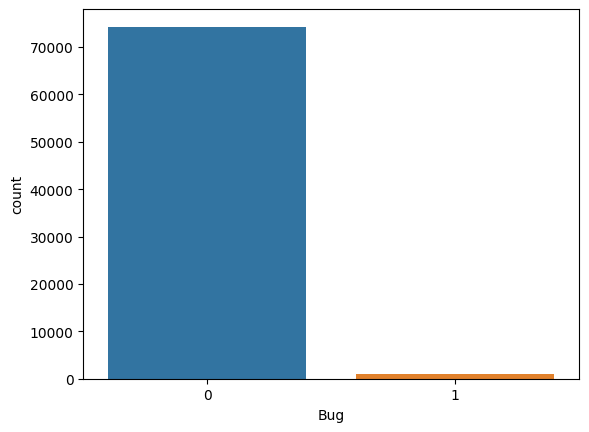

In [138]:
sns.countplot(dataset, x="Bug")

In [140]:
dataset.to_csv(OUTPUT_DIR + "dataset.csv", index=False)

# Preprocess data

In [141]:
dataset = pd.read_csv(OUTPUT_DIR + "dataset.csv")
dataset.head()

,AvgCyclomatic,AvgCyclomaticModified,AvgCyclomaticStrict,AvgEssential,AvgLine,AvgLineBlank,AvgLineCode,AvgLineComment,CountDeclClass,CountDeclClassMethod,...,AvgCountClassBase,AvgCountClassCoupled,AvgCountClassDerived,MaxInheritanceTree,AvgPercentLackOfCohesion,AvgCountInput,AvgCountOutput,AvgCountPath,MaxNesting,Bug
0,1.0,1.0,1.0,1.0,9.0,0.0,6.0,1.0,1.0,0.0,...,1.0,18.0,1.0,1.0,70.0,6.176471,3.941176,2.058824,2.0,0
1,2.0,2.0,2.0,1.0,8.0,0.0,7.0,0.0,2.0,0.0,...,1.5,8.5,0.0,1.0,33.5,6.142857,3.142857,2.666667,3.0,0
2,2.0,2.0,2.0,1.0,14.0,1.0,11.0,1.0,1.0,0.0,...,3.0,53.0,0.0,2.0,90.0,4.476190,4.142857,5.571429,4.0,0
3,2.0,2.0,2.0,1.0,29.0,1.0,13.0,14.0,1.0,0.0,...,1.0,26.0,0.0,1.0,0.0,8.750000,5.750000,2.750000,2.0,0
4,2.0,2.0,3.0,1.0,17.0,2.0,12.0,2.0,1.0,0.0,...,1.0,17.0,0.0,4.0,66.0,5.833333,8.500000,4.333333,2.0,0


### Correlation Matrix of Raw Data

<AxesSubplot: >

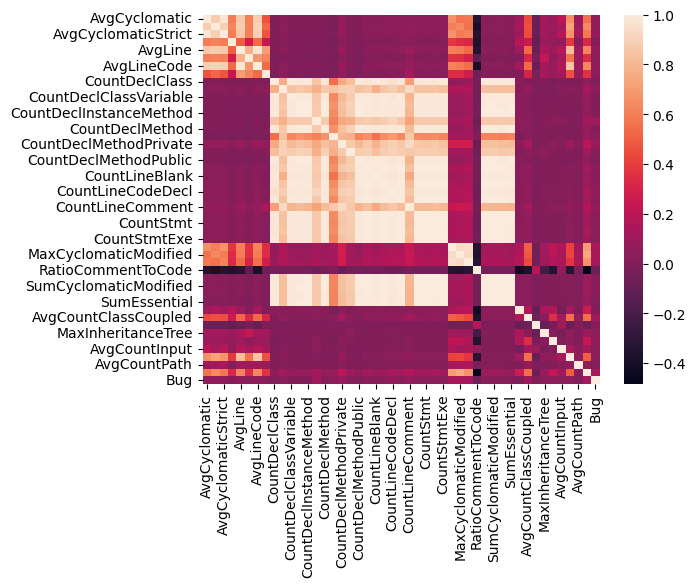

In [146]:
sns.heatmap(dataset.corr())

The heatmap above shows a highs correlations between most of the metrics. We will need to generate uncorrelated features highlighting attributes of interest from these metrics.

### Feature Generation

#### Generating Relative Metrics

In [155]:
dataset['AvgCyclomaticModifiedRatio'] = dataset['AvgCyclomaticModified'] / dataset['AvgCyclomatic']
dataset['AvgCyclomaticStrictRatio'] = dataset['AvgCyclomaticStrict'] / dataset['AvgCyclomatic']

dataset['AvgLineBlankRatio'] = dataset['AvgLineBlank'] / dataset['AvgLine']
dataset['AvgLineCodeRatio'] = dataset['AvgLineCode'] / dataset['AvgLine']
dataset['AvgLineCommentRatio'] = dataset['AvgLineComment'] / dataset['AvgLine']

dataset['CountDeclClassVariableRatio'] = dataset['CountDeclClassVariable'] / (dataset['CountDeclInstanceVariable'] +  dataset['CountDeclClassVariable'])
dataset['CountDeclClassMethodRatio'] = dataset['CountDeclClassMethod'] / dataset['CountDeclMethod']

dataset['CountDeclMethodDefaultRatio'] = dataset['CountDeclMethodDefault'] / dataset['CountDeclMethod']
dataset['CountDeclMethodPrivateRatio'] = dataset['CountDeclMethodPrivate'] / dataset['CountDeclMethod']
dataset['CountDeclMethodProtectedRatio'] = dataset['CountDeclMethodProtected'] / dataset['CountDeclMethod']
dataset['CountDeclMethodPublicRatio'] = dataset['CountDeclMethodPublic'] / dataset['CountDeclMethod']

dataset['CountDeclInstanceVariableRatio'] = dataset['CountDeclInstanceVariable'] / (dataset['CountDeclInstanceVariable'] +  dataset['CountDeclClassVariable'])
dataset['CountDeclInstanceMethodRatio'] =  dataset['CountDeclInstanceMethod'] / dataset['CountDeclMethod']

dataset['CountLineBlankRatio'] = dataset['CountLineBlank'] / dataset['CountLine']
dataset['CountLineCodeRatio'] = dataset['CountLineCode'] / dataset['CountLine']
dataset['CountLineCodeDeclRatio'] = dataset['CountLineCodeDecl'] / dataset['CountLine']
dataset['CountLineCodeExeRatio'] = dataset['CountLineCodeExe'] / dataset['CountLine']
dataset['CountLineCommentRatio'] = dataset['CountLineComment'] / dataset['CountLine']
dataset['CountSemicolonRatio'] = dataset['CountSemicolon'] / dataset['CountLine']

dataset['CountStmtDeclRatio'] = dataset['CountStmtDecl'] / dataset['CountStmt']
dataset['CountStmtExeRatio'] = dataset['CountStmtExe'] / dataset['CountStmt']

dataset['MaxCyclomaticModifiedRatio'] = dataset['MaxCyclomaticModified'] / dataset['MaxCyclomatic']
dataset['MaxCyclomaticStrictRatio'] = dataset['MaxCyclomaticStrict'] / dataset['MaxCyclomatic']

dataset['SumCyclomaticModifiedRatio'] = dataset['SumCyclomaticModified'] / dataset['SumCyclomatic']
dataset['SumCyclomaticStrictRatio'] = dataset['SumCyclomaticStrict'] / dataset['SumCyclomatic']

In [156]:
preprocessed_data = dataset[
    ['AvgCyclomatic', 'AvgCyclomaticModifiedRatio', 'AvgCyclomaticStrictRatio', 'AvgEssential', 
     'AvgLine', 'AvgLineBlankRatio', 'AvgLineCodeRatio', 'AvgLineCommentRatio', 
     'CountDeclClass', 'CountDeclClassMethodRatio', 'CountDeclClassVariableRatio', 'CountDeclFunction', 'CountDeclInstanceMethodRatio', 
     'CountDeclInstanceVariableRatio','CountDeclMethod', 'CountDeclMethodDefaultRatio', 'CountDeclMethodPrivateRatio', 
     'CountDeclMethodProtectedRatio', 'CountDeclMethodPublicRatio', 'CountLine', 'CountLineBlankRatio',
     'CountLineCodeRatio', 'CountLineCodeDeclRatio', 'CountLineCodeExeRatio', 'CountLineCommentRatio',
     'CountSemicolonRatio', 'CountStmt', 'CountStmtDeclRatio', 'CountStmtExeRatio', 'MaxCyclomatic',
     'MaxCyclomaticModifiedRatio', 'MaxCyclomaticStrictRatio', 'RatioCommentToCode', 'SumCyclomatic',
     'SumCyclomaticModifiedRatio', 'SumCyclomaticStrictRatio', 'SumEssential']
    +
    ["AvgCountClassBase", "AvgCountClassCoupled", "AvgCountClassDerived", "MaxInheritanceTree", "AvgPercentLackOfCohesion"]
    +
    ["AvgCountInput", "AvgCountOutput", "AvgCountPath", "MaxNesting"]
    +
    ["Bug"]
]

### Correlation Matrix

<AxesSubplot: >

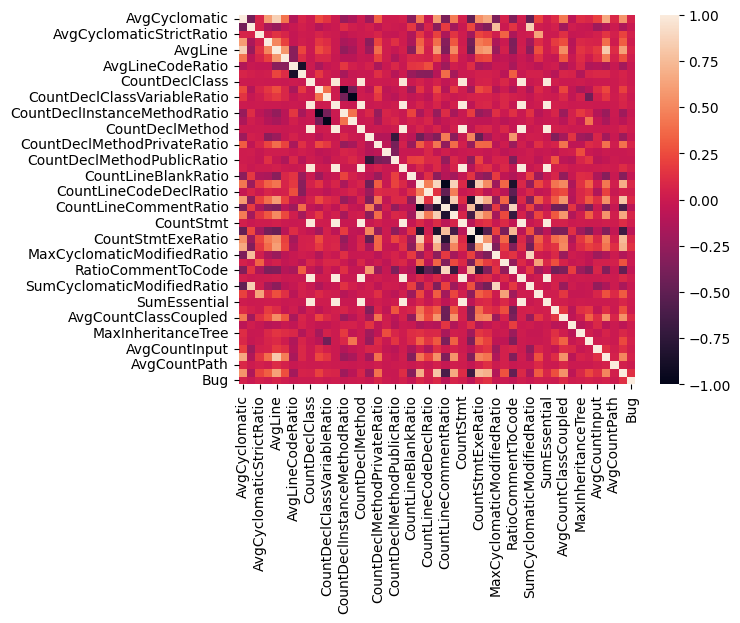

In [157]:
sns.heatmap(preprocessed_data.corr())

In [159]:
preprocessed_data.to_csv(OUTPUT_DIR + "dataset.csv", index=False)